In [2]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import OrderedDict
import common.layers as layers
from dataset.mnist import load_mnist
from common.trainer import Trainer

In [3]:
class SimpleMLP:
    def __init__(self, input_dim=(1, 28, 28), 
                 hidden_size1=100, hidden_size2=100, hidden_size3=100,
                 output_size=10, weight_init_std=0.01):
        """
        SimpleConvNet을 참고하여 MLP 형태로 만든 클래스.
        파라미터는 W1~W4, b1~b4 총 4세트를 사용.
        
        구조:
            (Affine1 -> Relu1) ->
            (Affine2 -> Relu2) ->
            (Affine3 -> Relu3) ->
            (Affine4 -> Softmax)
        
        input_dim  : (채널=1, 높이=28, 너비=28)
        hidden_size1,2,3 : 세 개의 은닉층 크기
        output_size : 최종 출력 차원(디폴트 10, MNIST용)
        weight_init_std : 가중치 초기화 스케일
        """
        # 입력을 펼쳤을 때의 차원 (1*28*28 = 784)
        input_size = input_dim[0] * input_dim[1] * input_dim[2]
        
        # 모든 파라미터를 딕셔너리에 저장
        self.params = {}
        
        # 1) W1, b1 (Affine1)
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size1)
        self.params['b1'] = np.zeros(hidden_size1)
        
        # 2) W2, b2 (Affine2)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        
        # 3) W3, b3 (Affine3)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size2, hidden_size3)
        self.params['b3'] = np.zeros(hidden_size3)
        
        # 4) W4, b4 (Affine4)
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size3, output_size)
        self.params['b4'] = np.zeros(output_size)
        
        # ---------------------------------------------------
        # 계층(Layers)들을 순서대로 쌓기
        # ---------------------------------------------------
        self.layers = OrderedDict()
        self.layers['Affine1'] = layers.Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1']   = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2']   = layers.Relu()
        self.layers['Affine3'] = layers.Affine(self.params['W3'], self.params['b3'])
        self.layers['Relu3']   = layers.Relu()
        self.layers['Affine4'] = layers.Affine(self.params['W4'], self.params['b4'])
        
        # 마지막 계층: 소프트맥스 + 크로스 엔트로피 손실
        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        """
        순전파(추론) 메서드
        x: (배치크기, 1, 28, 28) 형태라고 가정
        """
        # 2D로 펼치기: (batch_size, 784)
        x = x.reshape(x.shape[0], -1)
        
        # 순서대로 레이어 Forward
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        """
        손실 함수(크로스 엔트로피) 계산
        x: 입력데이터
        t: 정답레이블(원-핫 or 정수 라벨 모두 가능; SoftmaxWithLoss 구현에 따라 다름)
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        """
        정확도 측정
        """
        y = self.predict(x)
        y = np.argmax(y, axis=1)

        # t(정답)가 원-핫 벡터일 경우 argmax로 정수라벨 추출
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def gradient(self, x, t):
        """
        오차역전파를 통해 각 파라미터의 기울기를 구함
        반환: grads 딕셔너리 (W1, b1, W2, b2, W3, b3, W4, b4)
        """
        # 1) 순전파 (loss 계산)
        self.loss(x, t)

        # 2) 역전파
        dout = 1
        dout = self.last_layer.backward(dout)  # SoftmaxWithLoss 거꾸로
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 3) 각 파라미터의 기울기를 grads에 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db

        return grads

    def save_params(self, file_name="params.pkl"):
        """
        파라미터(가중치, 편향) 저장
        """
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        """
        파라미터(가중치, 편향) 로드
        """
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        # 로드한 파라미터를 실제 레이어에 반영
        for i, key in enumerate(['Affine1', 'Affine2', 'Affine3', 'Affine4']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [6]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

mlp = SimpleMLP(input_dim=(1, 28, 28))

# 학습 수행
trainer = Trainer(mlp, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

train loss:2.302177286049988
=== epoch:1, train acc:0.087, test acc:0.089 ===
train loss:2.302413729631005
train loss:2.3024404526006332
train loss:2.3022028942253754
train loss:2.3017414806692345
train loss:2.3018765069572735
train loss:2.3014807384300373
train loss:2.3004735462747945
train loss:2.3002413552812255
train loss:2.2983352989972654
train loss:2.2955754536762045
train loss:2.292730299679528
train loss:2.289624627027066
train loss:2.2851550697809087
train loss:2.2784489096306753
train loss:2.268981895013188
train loss:2.2689887974373604
train loss:2.2497725352763096
train loss:2.234085271052611
train loss:2.21601219348631
train loss:2.189254527852499
train loss:2.1660681665683397
train loss:2.1729794483140754
train loss:2.0958575016985828
train loss:2.10279939308742
train loss:2.024423298634274
train loss:2.0062818823005766
train loss:1.9045457404621684
train loss:1.8993744790075175
train loss:1.7790487602506053
train loss:1.764213950488266
train loss:1.7108051912070426
trai

In [ ]:
mlp.save_params("params_self.pkl")
print("Saved Network Parameters!")

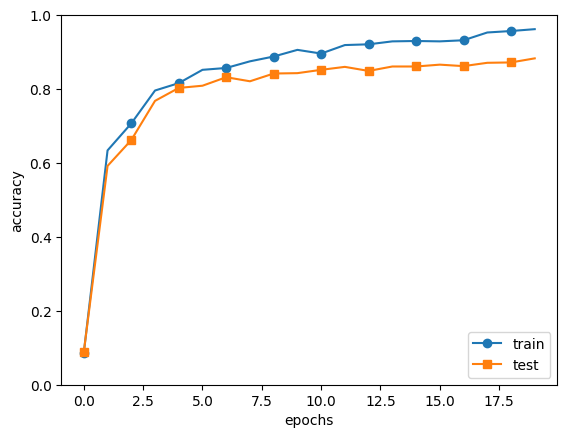

In [7]:

markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()